********************

#### 탐색 결과를 소개하기 앞서 대회에서 제공하는 해당 데이터는 대회 진행을 목적으로 적합한 샘플링 작업을 거친 데이터라는 점을 알려드립니다.

#### 소개할 내용들이 <font color = "red">실제 멜론 유저의 소비 패턴과는 전혀 무관</font>하며, <font color = "red">멜론 DJ 플레이리스트 서비스를 일반화할 수 없음</font>을 참고하여 주시기 바랍니다.

********************

# KAKAO Arena 3rd Compitition : Melon Playlist Continuation

## 대회 데이터 간단하게 EDA

<br><br><br><br><br>

In [1]:
from datetime import timedelta, datetime 
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from konlpy.tag import Twitter
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# wordcloud = WordCloud(font_path='font/NanumGothic.ttf', background_color='white').generate(text)


# font_path = 'C:\Users\medici\anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlib\rcNanumGothic.ttf'
# font_name = fm.FontProperties(fname=font_path, size=10).get_name()
# plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')

In [2]:
pd.options.mode.chained_assignment = None

<br><br><br><br><br><br><br><br><br><br>

## 1. 곡 장르 코드 데이터 : `genre_gn_all.json`

### 데이터 불러오기 

In [3]:
genre_gn_all = pd.read_json('data/genre_gn_all.json', typ = 'series') # 장르 읽어오기

In [4]:
# 장르코드 : gnr_code, 장르명 : gnr_name
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

In [5]:
genre_gn_all.T

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
gnr_code,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,GN0203,...,GN2802,GN2803,GN2804,GN2805,GN2806,GN2900,GN2901,GN2902,GN2903,GN3000
gnr_name,발라드,세부장르전체,'80,'90,'00,'10-,댄스,세부장르전체,'80,'90,...,ASMR/자연,힐링/명상/요가,집중력,숙면유도,반려동물,뮤지컬,세부장르전체,국내뮤지컬,국외뮤지컬,크리스마스


- 장르 코드는 **총 254개의 장르코드가 존재**하며 **30개의 대분류 장르코드**와 **224개의 상세 장르코드**로 분류할 수 있습니다.

<br>

### 대분류 장르코드 

- 대분류 장르코드는 장르코드(`gnr_code`)에서 **숫자 네 자리 중 뒷자리 두 자리가 `00`인 코드로 분류**할 수 있습니다.
- 대분류 장르는 총 30개가 있습니다.

In [6]:
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']

gnr_code.describe()

,gnr_code,gnr_name
count,30,30
unique,30,26
top,GN0100,랩/힙합
freq,1,2


> **장르 이름 5개 중복  
> 12	GN0300	랩/힙합, 90	GN1200	랩/힙합      
18	GN0400	R&B/Soul, 100	GN1300	R&B/Soul    
32	GN0600	록/메탈, 65	GN1000	록/메탈    
50	GN0800	포크/블루스, 109	GN1400	포크/블루스/컨트리 => 얘만 3개야       
80	GN1100	일렉트로니카, 232	GN2600	일렉트로니카**  


In [7]:
gnr_code.T

,0,6,12,18,22,32,39,50,56,65,...,187,198,215,218,225,232,237,242,249,253
gnr_code,GN0100,GN0200,GN0300,GN0400,GN0500,GN0600,GN0700,GN0800,GN0900,GN1000,...,GN2100,GN2200,GN2300,GN2400,GN2500,GN2600,GN2700,GN2800,GN2900,GN3000
gnr_name,발라드,댄스,랩/힙합,R&B/Soul,인디음악,록/메탈,성인가요,포크/블루스,POP,록/메탈,...,CCM,어린이/태교,종교음악,국악,아이돌,일렉트로니카,EDM,뮤직테라피,뮤지컬,크리스마스


<br>

### 상세 장르코드

- 상세 장르코드는 장르코드(`gnr_code`)에서 **숫자 네 자리 중 뒷자리 두 자리가 `00`이 아닌 나머지 코드로 분류**할 수 있습니다.
- 상세 장르는 총 224개가 있습니다.

In [8]:
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

In [9]:
dtl_gnr_code.T

,1,2,3,4,5,7,8,9,10,11,...,241,243,244,245,246,247,248,250,251,252
dtl_gnr_code,GN0101,GN0102,GN0103,GN0104,GN0105,GN0201,GN0202,GN0203,GN0204,GN0205,...,GN2704,GN2801,GN2802,GN2803,GN2804,GN2805,GN2806,GN2901,GN2902,GN2903
dtl_gnr_name,세부장르전체,'80,'90,'00,'10-,세부장르전체,'80,'90,'00,'10-,...,DJ,세부장르전체,ASMR/자연,힐링/명상/요가,집중력,숙면유도,반려동물,세부장르전체,국내뮤지컬,국외뮤지컬


<br>

### 장르 코드 트리(Tree)

- 위에서 구분한 **대분류 장르코드와 상세 장르코드 앞자리 네 자리를 활용**하여 장르 코드 트리도 구성해볼 수 있습니다.

In [10]:
# 앞자리 네 자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']].T

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
gnr_code,GN0100,GN0100,GN0100,GN0100,GN0100,GN0200,GN0200,GN0200,GN0200,GN0200,...,GN2800,GN2800,GN2800,GN2800,GN2800,GN2800,GN2900,GN2900,GN2900,GN3000
gnr_name,발라드,발라드,발라드,발라드,발라드,댄스,댄스,댄스,댄스,댄스,...,뮤직테라피,뮤직테라피,뮤직테라피,뮤직테라피,뮤직테라피,뮤직테라피,뮤지컬,뮤지컬,뮤지컬,크리스마스
dtl_gnr_code,GN0101,GN0102,GN0103,GN0104,GN0105,GN0201,GN0202,GN0203,GN0204,GN0205,...,GN2801,GN2802,GN2803,GN2804,GN2805,GN2806,GN2901,GN2902,GN2903,NaN
dtl_gnr_name,세부장르전체,'80,'90,'00,'10-,세부장르전체,'80,'90,'00,'10-,...,세부장르전체,ASMR/자연,힐링/명상/요가,집중력,숙면유도,반려동물,세부장르전체,국내뮤지컬,국외뮤지컬,NaN


In [11]:
# POP 장르(GN0900)의 상세 장르 살펴보기
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN3000']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
224,GN3000,크리스마스,GN30,NaN,NaN


> **dtl_gnr_code, dtl_gnr_name NaN값을 가짐 => 대장르 만들어주기**

In [12]:
# 어린이/테교 장르(GN2200)의 상세 장르 살펴보기
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN0200']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
5,GN0200,댄스,GN02,GN0201,세부장르전체
6,GN0200,댄스,GN02,GN0202,'80
7,GN0200,댄스,GN02,GN0203,'90
8,GN0200,댄스,GN02,GN0204,'00
9,GN0200,댄스,GN02,GN0205,'10-


> **같은 대분류 속 상세분류(dtl_gnr_name)가 중복되기도 함.   
179	GN2200	어린이/태교	GN22	GN2203	영어동요   
180	GN2200	어린이/태교	GN22	GN2204	영어동요   
181	GN2200	어린이/태교	GN22	GN2205	영어동요**   
세부장르 년도 + 장르 / 장르 / 년도.

<br><br><br>

## 2. 곡 별 메타 데이터 : `song_meta.json`

### 데이터 불러오기

In [13]:
song_meta = pd.read_json('data/song_meta.json', typ = 'frame')

In [14]:
# 발매년도 만들기 str타입
song_meta['issue_date'] = song_meta['issue_date'].astype(str)
song_meta['issue_Y'] = song_meta['issue_date'].str[:4]
song_meta['issue_m'] = song_meta['issue_date'].str[4:6]
song_meta['issue_d'] = song_meta['issue_date'].str[6:]

song_meta.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,issue_Y,issue_m,issue_d
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0,2014,05,12
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1,2008,04,21
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2,2018,05,18
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3,2015,10,16
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4,2011,08,24


---

In [15]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  object
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
 9   issue_Y                 707989 non-null  object
 10  issue_m                 707989 non-null  object
 11  issue_d                 707989 non-null  object
dtypes: int64(2), object(10)
memory usage: 64.8+ MB


- **총 707,989곡의 메타 정보가 담겨 있으며** 포함하는 값은 아래와 같습니다.
  + `song_gn_dtl_gnr_basket` : 상세 장르 코드
  + `issue_date` : 곡 발매 일자 (yyyymmdd)
  + `album_name` : 앨범 명
  + `album_id` : 앨범 아이디
  + `artist_id_basket` : 아티스트 아이디 (복수일 경우 띄어쓰기로 구분)
  + `song_name` : 곡 명
  + `song_gn_gnr_basket` : 대분류 장르코드
  + `artist_name_basket` : 아티스트 명 (복수일 경우 띄어쓰기로 구분)
  + `id` : 곡 아이디
 
> **album_name, song_name, artist_name_basket 영어, 한국어 혼합 및 형태소 분석 주의   
song_gn_dtl_gnr_basket xx01 대분류장르코드는 모든 곡에 공통 들어가있다.(크리스마스곡 제외)     
리스트로 묶여있는 칼럼 목록 : song_gn_dtl_gnr_basket, artist_id_basket, song_gn_gnr_basket, artist_name_basket**   

In [16]:
cat_columns = [c for c, t in zip(song_meta.dtypes.index, song_meta.dtypes) if t=='O'] 
num_columns = [c for c in song_meta.columns if c not in cat_columns]

print(f'Categorical Columns: \n{cat_columns}\n')
print(f'Numeric Columns: \n{num_columns}\n')

Categorical Columns: 
['song_gn_dtl_gnr_basket', 'issue_date', 'album_name', 'artist_id_basket', 'song_name', 'song_gn_gnr_basket', 'artist_name_basket', 'issue_Y', 'issue_m', 'issue_d']

Numeric Columns: 
['album_id', 'id']



In [17]:
# song_meta.describe(include='O').T

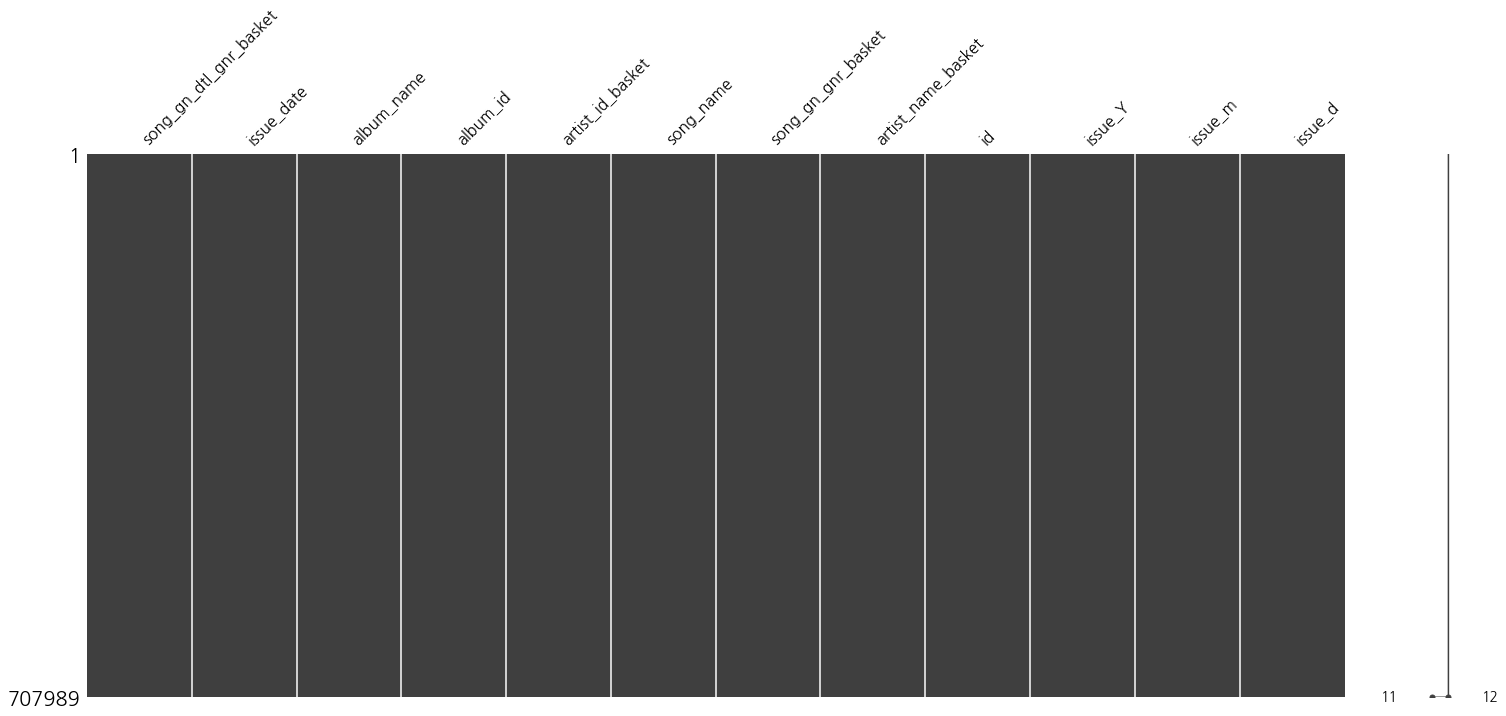

song_gn_dtl_gnr_basket    0.000000
issue_date                0.000000
album_name                0.000565
album_id                  0.000000
artist_id_basket          0.000000
song_name                 0.000000
song_gn_gnr_basket        0.000000
artist_name_basket        0.000000
id                        0.000000
issue_Y                   0.000000
issue_m                   0.000000
issue_d                   0.000000
dtype: float64

In [18]:
import missingno as msno
msno.matrix(song_meta, sort='descending')
plt.show()

song_meta.isna().sum() / len(song_meta) * 100 # NaN, Null

> **album_name 0.000565 소량이지만 결측치 존재
앨범 이름이라 크게 중요하지는 않다고 판단.**

In [19]:
print(song_meta['album_name'].value_counts().head())

print(song_meta['album_id'].value_counts().head())

Greatest Hits     930
The Collection    399
Best Of           294
Love Songs        247
Home              236
Name: album_name, dtype: int64
2173174     142
300601      138
10261494    138
324341      136
10058860    114
Name: album_id, dtype: int64


In [20]:
song_meta['artist_id_basket'].isna().sum()

0

In [21]:
# artist_id가 object로 나옴.
# 같은 곡 안에 가수가 여럿일 경우에 ,로 구분됨
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  object
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
 9   issue_Y                 707989 non-null  object
 10  issue_m                 707989 non-null  object
 11  issue_d                 707989 non-null  object
dtypes: int64(2), object(10)
memory usage: 64.8+ MB


In [22]:
song_meta['artist_id_basket'] = song_meta['artist_id_basket'].str.strip('[]')

In [23]:
song_meta

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,issue_Y,issue_m,issue_d
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,NaN,Feelings,[GN0900],[Various Artists],0,2014,05,12
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,NaN,"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1,2008,04,21
2,[GN0901],20180518,Hit,4698747,NaN,Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2,2018,05,18
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,NaN,Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3,2015,10,16
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,NaN,그남자 그여자,[GN1800],[Jude Law],4,2011,08,24
...,...,...,...,...,...,...,...,...,...,...,...,...
707984,[GN2001],19991219,The Best Best Of The Black President,65254,NaN,Coffin For Head Of State,[GN2000],[Fela Kuti],707984,1999,12,19
707985,[GN0901],19860000,True Colors,44141,NaN,Change Of Heart,[GN0900],[Cyndi Lauper],707985,1986,00,00
707986,"[GN0105, GN0101]",20160120,행보 2015 윤종신 / 작사가 윤종신 Live Part.1,2662866,NaN,스치듯 안녕,[GN0100],[윤종신],707986,2016,01,20
707987,"[GN1807, GN1801]",20131217,명상의 시간을 위한 뉴에이지 음악,2221722,NaN,숲의 빛,[GN1800],[Nature Piano],707987,2013,12,17


In [24]:
print(list(song_meta[song_meta['album_name']=='Greatest Hits']['artist_name_basket']))

[['Little River Band'], ['Sweetbox'], ['N Sync'], ['Motley Crue'], ['Scouting For Girls'], ['Marvin Gaye and Tammi Terrell'], ['The Drifters'], ['Chet Baker'], ['Expose'], ['Ramones'], ['Ruff Endz'], ['The Notorious B.I.G.'], ['Exile'], ['Chet Baker'], ['Kathy Troccoli'], ['The Fugees'], ['Lee Ann Womack'], ['Dido'], ['The Cover Girls'], ['Earth, Wind & Fire'], ['Mose Allison'], ['Air Supply'], ['Whodini'], ['Mariah Carey'], ['Doug Stone'], ['Amy Grant'], ['Joe'], ['Mariah Carey'], ['Rod Stewart'], ['Little Anthony & The Imperials'], ['The Bangles'], ['Chet Baker'], ['SWV'], ['N.W.A.'], ['Motley Crue'], ['Little River Band'], ['Styx'], ['Nas'], ['Dean Martin'], ['Mariah Carey'], ['Foo Fighters'], ['Bruce Springsteen'], ['Santana'], ['Johnny Lee'], ['Ramones'], ['Sweetbox'], ['Kenny Rogers'], ['Mariah Carey'], ['Fu-Schnickens'], ['John Williams'], ['The Psychedelic Furs'], ['Train'], ['The Notorious B.I.G.'], ['The Brothers Four'], ['Will Smith'], ['Kool Moe Dee'], ['Richard Marx'], ['J

> **album_name은 같아도 다른 album_id 가지고 있음**

---

In [25]:
from tqdm import notebook

In [26]:
train = pd.read_json('data/train.json', encoding='utf-8-sig')

In [27]:
meta = song_meta.copy()

In [28]:
album_list = meta['album_id'].values
artist_list = meta['artist_name_basket'].values

# 동일 앨범의 수록곡에 대한 개수 
e = Counter()

# 동일 가수에 대한 개수(단, various Artist는 제외)
f = Counter()

# 플레이 리스트별 동일 앨범, 가수의 최대수
album_cnt = []; singer_cnt = []; 
for i in notebook.tqdm(train['songs']):
    c = Counter() # { song_id : cnt }
    d = Counter() # { artist : cnt }
    for j in i:  
        # index와 곡의 번호가 동일
        c.update({album_list[j]: 1}) # 앨범명
        if artist_list[j][0] == 'Various Artists': continue
        d.update({artist_list[j][0]: 1}) # Various Artists는 무시하고
    
    album_cnt.append(max(c.values()))
    
    # 모든 앨범의 곡이 Various Artists인 경우 
    try: singer_cnt.append(max(d.values())) 
    except: singer_cnt.append(1)
    
    for k in c.values(): 
        e.update({k: 1})
        
    for k in d.values(): 
        f.update({k: 1})

  0%|          | 0/115071 [00:00<?, ?it/s]

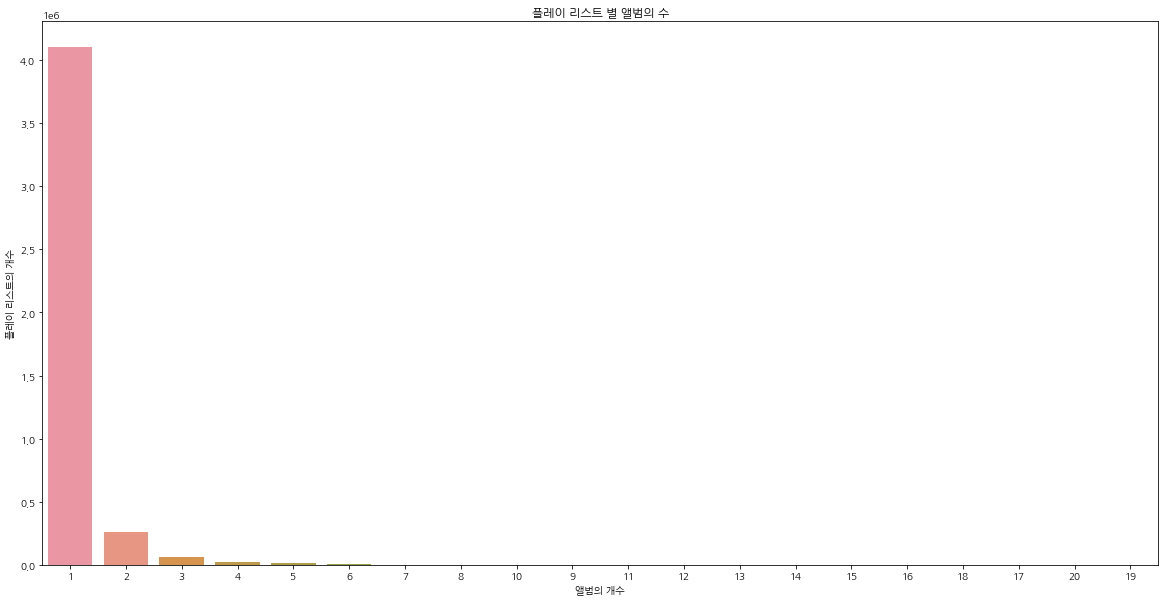

In [29]:
# 1. 동일 앨범의 수록 수에 대한 데이터프레임을 완성 
album_df = pd.DataFrame(data = np.array([list(e.keys()), list(e.values())]).T, columns=['동일 앨범의 수록 수', '전체 사용자의 갯수'])
album_df = album_df.sort_values(by='전체 사용자의 갯수', ascending=False).reset_index(drop=True)

# 2. 시각화 
album_plot = sns.barplot(x = '동일 앨범의 수록 수', y = '전체 사용자의 갯수', data = album_df.head(20), order = album_df['동일 앨범의 수록 수'].head(20))
album_plot.set_title('플레이 리스트 별 앨범의 수')
album_plot.set_xlabel('앨범의 개수')
album_plot.set_ylabel('플레이 리스트의 개수')
plt.xticks(rotation = 0)
plt.show()

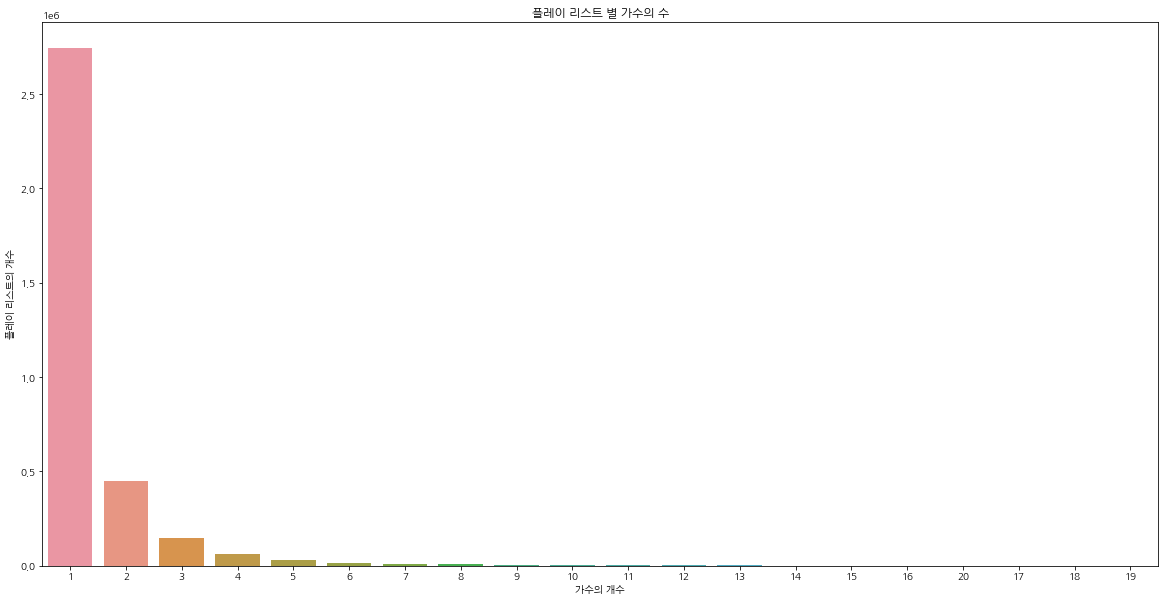

In [30]:
# 1. 동일 가수의 수록 수에 대한 데이터프레임을 완성 
singer_df = pd.DataFrame(data = np.array([list(f.keys()), list(f.values())]).T, columns=['동일 가수의 수록 수', '전체 사용자의 갯수'])
singer_df = singer_df.sort_values(by='전체 사용자의 갯수', ascending=False).reset_index(drop=True)

# 2. 시각화 
singer_df_plot = sns.barplot(x = '동일 가수의 수록 수', y = '전체 사용자의 갯수', data = singer_df.head(20), order = singer_df['동일 가수의 수록 수'].head(20))
singer_df_plot.set_title('플레이 리스트 별 가수의 수')
singer_df_plot.set_xlabel('가수의 개수')
singer_df_plot.set_ylabel('플레이 리스트의 개수')
plt.xticks(rotation = 0)
plt.show()

---

In [31]:
print(song_meta['song_gn_gnr_basket'].value_counts().head())

[GN0900]    64752
[GN1600]    56557
[GN1000]    52830
[GN1100]    49710
[GN1700]    48176
Name: song_gn_gnr_basket, dtype: int64


In [32]:
print(song_meta['issue_Y'].value_counts().head())

2015    65314
2017    63008
2018    59489
2016    58016
2014    54305
Name: issue_Y, dtype: int64


<br>

In [33]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

### 곡 별 매핑 되는 장르 수는?

In [34]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

In [35]:
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [36]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

# 3. 2번 테이블에 비율 값 추가
gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.69
1,2,92378,13.07
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


- **대부분의 곡들은 한 개의 대분류 장르와 매핑**되어 있습니다.
- 전체 곡의 약 13%는 2개 이상의 대분류 장르를 가지며 아래 임의 예시입니다.

In [37]:
#song_gnr_count[song_gnr_count['mapping_gnr_cnt'] >= 2]
song_meta[song_meta['id'] == 456506] 

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,issue_Y,issue_m,issue_d
456506,"[GN0403, GN0101, GN1501, GN1504]",20060731,오버 더 레인보우 OST,321962,NaN,그리운 건 어쩔 수 없어,"[GN0400, GN1500, GN0100]",[환희],456506,2006,07,31


<br>

### 가장 많이 매핑 되는 장르는?

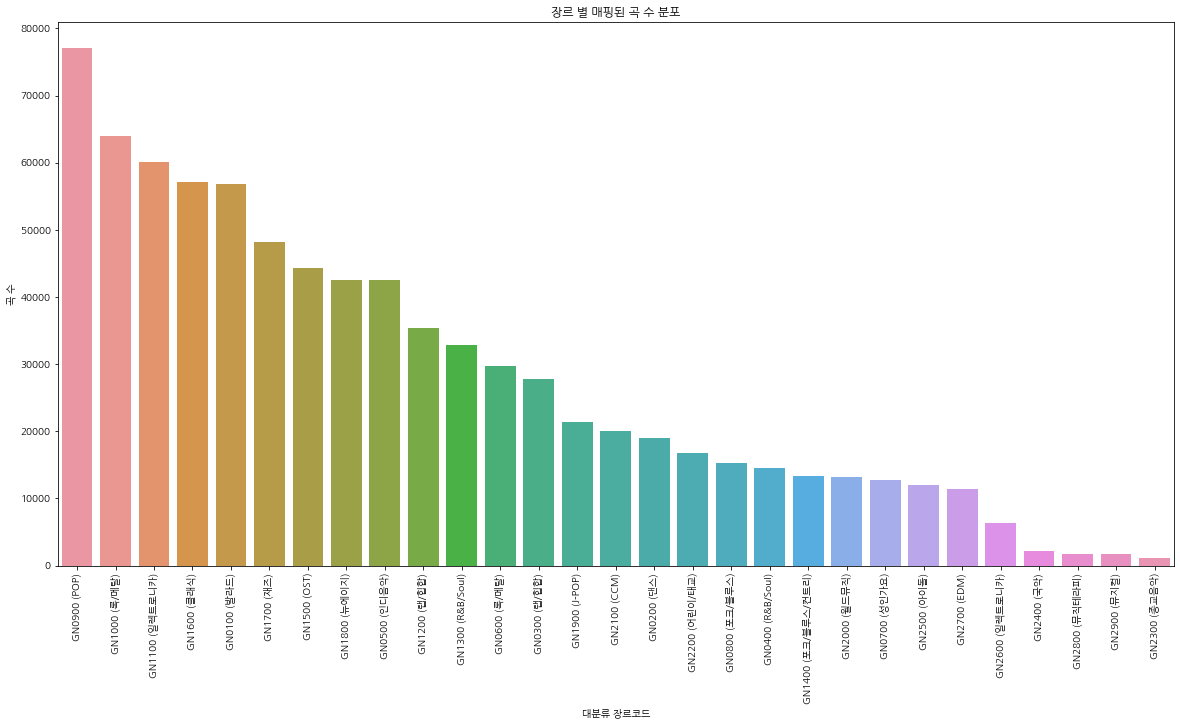

In [38]:
# 1. 장르 별 곡 수 count 테이블 생성 : gnr_count
gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')

# 2. 1번 테이블과 장르 meta와 join
gnr_count = pd.merge(gnr_count, gnr_code.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'

# 3. 매핑이 되지 않은 일부 곡들은 제거
gnr_count = gnr_count[['gnr_code_name', 'song_cnt']].dropna()

# 4. 많은 곡이 매핑된 순 기준으로 내림차순 리스트 생성
gnr_list_desc = gnr_count.sort_values('song_cnt', ascending = False).gnr_code_name

# 5. plotting
gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = gnr_count, order = gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

- **POP 장르(`GN0900`)의 곡 비중이 가장 높았고**, 국악, 뮤지컬, 뮤직테라피, 종교음악 등의 장르 비중은 1% 미만의 비중을 보입니다.
- 아이돌 아티스트 관련 장르인 아이돌 장르(`GN2500`)와 댄스 장르(`GN0200`) 비중도 비교적 낮게 나타나는 점이 보입니다.

<br>

---

### 발매 년도 별 곡 비중은?

2015    65314
2017    63008
2018    59489
2016    58016
2014    54305
Name: issue_Y, dtype: int64


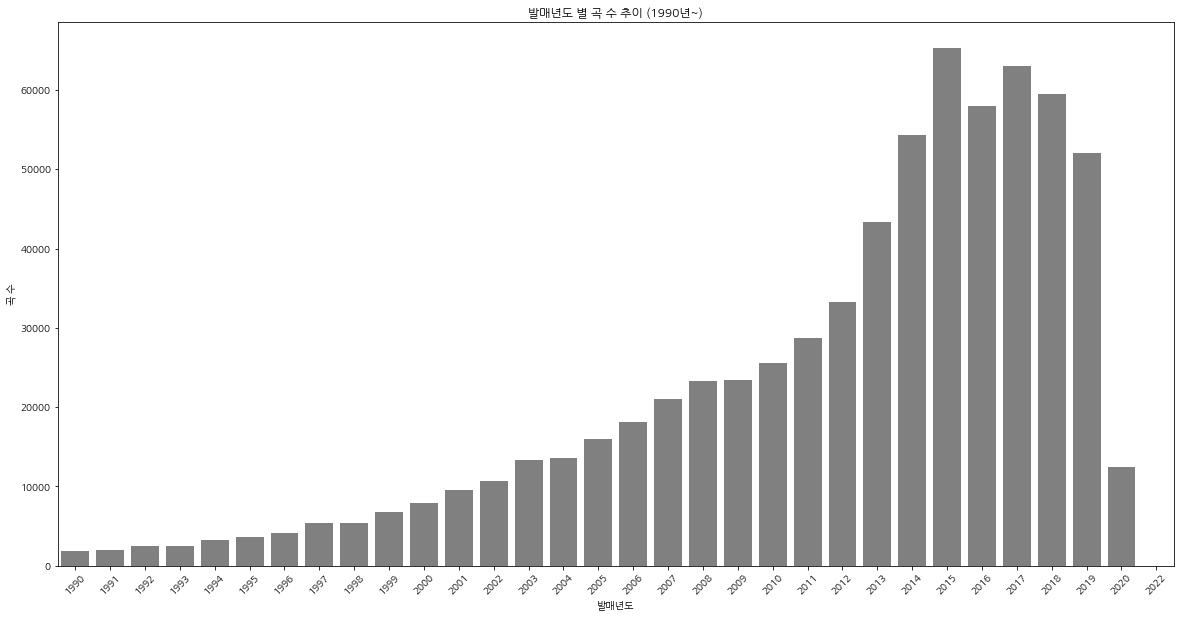

In [39]:
print(song_meta['issue_Y'].value_counts().head())
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_Y) 변수 생성
song_issue_date['issue_Y'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)
# song_issue_date['']

# 3. 1990년도~ 필터링
song_issue_date_filter = song_issue_date[song_issue_date.issue_Y >= '1990']

# 4. 발매년도 별 곡 수 count 테이블 생성 : issue_Y_song_cnt
issue_Y_song_cnt = song_issue_date_filter.groupby('issue_Y').song_id.nunique().reset_index(name = 'song_cnt')

# 5. plotting
issue_Y_song_cnt_plot = sns.barplot(x = 'issue_Y', y = 'song_cnt', data = issue_Y_song_cnt, color = 'grey')
issue_Y_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_Y_song_cnt_plot.set_xlabel('발매년도')
issue_Y_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation = 45)
plt.show()

- 1990년 이후로 각 곡들의 발매년도 별 곡의 비중을 확인해본 결과 **2014~2019년도에 발매된 곡의 비중**이 높았습니다.  
  (실제 전체 메타 풀에서 약 50% 정도의 비중을 보임)

<br><br><br>

## 3. 학습 데이터 : `train.json`

### 데이터 불러오기

In [40]:
train = pd.read_json('train.json', typ = 'frame')

ValueError: Unexpected character found when decoding 'true'

In [ ]:
train.head(2)

In [ ]:
train.info()

- 학습 데이터에는 **총 115,071개 플레이리스트 정보가 담겨져 있으며** 포함하는 값은 아래와 같습니다.
  + `tags` : 플레이리스트에 매핑된 태그
  + `id` : 플레이리스트 아이디
  + `plylst_title` : 플레이리스트 명
  + `songs` : 플레이리스트 내 수록된 곡 아이디
  + `like_cnt` : 플레이리스트 좋아요 횟수
  + `updt_date` : 플레이리스트 업데이트 일시

In [ ]:
# train['tags_str'] = train['tags'].map(lambda x : " ".join(x))
# train.head(2)

In [ ]:
top3000df = train.sort_values('like_cnt',ascending = False).head(3000)

In [ ]:
top3000_tag_list = np.concatenate( top3000df['tags'].values )
pd.Series(top3000_tag_list).value_counts().head(10)

In [ ]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = train[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# unnest 객체 제거
del plylst_song_map_unnest

In [ ]:
plylst_song_map

In [ ]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

In [ ]:
plylst_tag_map

In [ ]:
train_uniq_song_cnt = plylst_song_map.songs.nunique() # 유니크 곡 수
train_uniq_tag_cnt = plylst_tag_map.tags.nunique() # 유니크 태그 수

print('곡 수 : %s' %train_uniq_song_cnt)
print('태그 수 : %s' %train_uniq_tag_cnt)

<br>

### 플레이리스트 별 곡/태그/장르 수 분포는?

#### 수록곡 

In [ ]:
# 1. 플레이리스트 별 수록곡 수 count 테이블 생성 : plylst_song_cnt
plylst_song_cnt = pd.DataFrame(plylst_song_map.groupby('id').songs.nunique())

# 2-1. grid setting
grid_list = [i*2 for i in range(1, 101)]

# 2-2. plotting
plt.hist(plylst_song_cnt['songs'], grid_list, color = "lightgrey", edgecolor = "black")
plt.show()

In [ ]:
round(plylst_song_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

- 플레이리스트 별 수록된 곡 수의 분포를 확인해본 결과 **평균 약 46개**(중앙값 30개)**의 곡이 수록**되어 있으며 최대 200곡의 수록곡을 포함한 플레이리스트가 존재합니다.

###### 중앙값30개
---

#### 태그

In [ ]:
# 1. 플레이리스트 별 매핑 태그 수 count 테이블 생성 : plylst_tag_cnt
plylst_tag_cnt = pd.DataFrame(plylst_tag_map.groupby('id').tags.nunique())

# 2. plotting
plt.hist(plylst_tag_cnt['tags'], range(1, 12), color = "lightgrey", edgecolor = "black")
plt.show()

In [ ]:
round(plylst_tag_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

- 플레이리스트 당 **태그는 평균 약 4.1개**(중앙값 3개)**가 포함**되어 있으며 가장 많은 태그 수는 11개 입니다.

#### 장르

In [ ]:
# 1-1. join 목적으로 곡 아이디 integer to string 변환
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# 1-2. 플레이리스트-곡 테이블 plylst_song_map + 곡-장르 테이블 song_gnr_map join
plylst_song_gnr_map = pd.merge(plylst_song_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 2. 플레이리스트 별 곡 장르 수 count 테이블 생성 : plylst_song_gnr_cnt
plylst_song_gnr_cnt = pd.DataFrame(plylst_song_gnr_map.groupby('id').gnr_code.nunique())

# 3. plotting
plt.hist(plylst_song_gnr_cnt['gnr_code'], range(0, 31), color = "lightgrey", edgecolor = "black")
plt.show()

In [ ]:
round(plylst_song_gnr_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

- 플레이리스트에 수록된 곡에서 대분류 장르 수 분포를 확인해본 결과 플레이리스트 당 **평균 6.6개**(중앙값 6개)**의 장르를 포함**하고 있습니다. 

<br>

### 곡/태그/플레이리스트명 중복 비율은?

#### 중복 수록 곡 비중

In [ ]:
# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 수록 구분 : 곡 별 수록된 플레이리스트가 한 개면 '단일 수록', 두 개 이상이면 '중복 수록'
song_plylst_cnt = song_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(song_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 수록', '중복 수록'])
)

# 3. 단일/중복 수록 구분 별 곡 수 count 테이블 생성 : song_plylst_mapping_division
song_plylst_mapping_division = pd.DataFrame(song_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
song_plylst_mapping_division.rename(columns = {'songs' : '곡 수'}, inplace = True)
song_plylst_mapping_division.loc[:, '비율(%)'] = round(song_plylst_mapping_division['곡 수']/sum(song_plylst_mapping_division['곡 수'])*100, 2)
song_plylst_mapping_division = song_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 수록 여부'})
song_plylst_mapping_division[['중복 수록 여부', '곡 수', '비율(%)']]

- **수록 곡의 약 51%는 두 개 이상의 플레이리스트에 중복 수록**된 곡 입니다.

#### 아래는 중복 수록 곡 중 많이 수록된 횟수 기준 상위 30곡 입니다.

In [ ]:
# 1. song_plylst_cnt 테이블에서 중복 수록 곡 중 수록 횟수 기준 상위 30곡 필터링 테이블 생성 : duplicate_song_top30
duplicate_song_top30 = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '중복 수록'].nlargest(30, 'mapping_plylst_cnt')

# 2-1. join 목적으로 곡 아이디 integer to string 변환
duplicate_song_top30['songs'] = duplicate_song_top30['songs'].astype(str)
song_meta['id'] = song_meta['id'].astype(str)

# 2-2 상위 30곡 테이블 duplicate_song_top30 + 곡 메타 song_meta join
(
    pd.merge(duplicate_song_top30, song_meta[['id', 'song_name', 'artist_name_basket']],
             how = 'left', left_on = 'songs', right_on = 'id')
    [['songs', 'song_name', 'artist_name_basket', 'mapping_plylst_cnt']]
    .rename(columns = {'songs' : '곡 아이디', 'song_name' : '곡 명', 'artist_name_basket' : '아티스트 명', 'mapping_plylst_cnt' : '수록 횟수'})
)

#### 아래는 단일 수록 곡 중 가장 많은 곡이 수록된 장르 상위 30개 입니다.

In [ ]:
# 1. song_plylst_cnt 테이블에서 단일 수록 곡만 필터링 하여 테이블 생성 : single_song
single_song = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '단일 수록']

# 2-1. join 목적으로 곡 아이디 integer to string 변환
single_song['songs'] = single_song['songs'].astype(str)

# 2-2. 단일 수록 곡 테이블 single_song + 곡 메타 song_meta join : 아티스트 기준 single_song_artist, 장르 기준 single_song_gnr
single_song_artist = pd.merge(single_song, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
single_song_gnr = pd.merge(single_song, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 수록 곡 개수 기준 상위 30개 장르 : single_song_gnr_cnt
single_song_gnr_cnt = single_song_gnr.groupby('gnr_code').songs.nunique().reset_index(name = 'song_cnt')
(
    pd.merge(single_song_gnr_cnt, genre_gn_all, how = 'left', on = 'gnr_code')[['gnr_code', 'gnr_name', 'song_cnt']]
    .rename(columns = {'gnr_code' : '대분류 장르코드', 'gnr_name' : '장르명', 'song_cnt' : '수록 곡 수'})
    .sort_values('수록 곡 수', ascending = False)
)

<br>

#### 중복 매핑 태그 비중

In [ ]:
# 1. 태그 별 수록된 플레이리스트 개수 count 테이블 생성 : tag_plylst_cnt
tag_plylst_cnt = plylst_tag_map.groupby('tags').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 매핑 구분 : 태그 별 매핑된 플레이리스트가 한 개면 '단일 매핑', 두 개 이상이면 '중복 매핑'
tag_plylst_cnt = tag_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(tag_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 매핑', '중복 매핑'])
)

# 3. 단일/중복 매핑 구분 별 태그 수 count 테이블 생성 : tag_plylst_mapping_division
tag_plylst_mapping_division = pd.DataFrame(tag_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
tag_plylst_mapping_division.rename(columns = {'tags' : '태그 수'}, inplace = True)
tag_plylst_mapping_division.loc[:, '비율(%)'] = round(tag_plylst_mapping_division['태그 수']/sum(tag_plylst_mapping_division['태그 수'])*100, 2)
tag_plylst_mapping_division = tag_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 매핑 여부'})
tag_plylst_mapping_division[['중복 매핑 여부', '태그 수', '비율(%)']]

- 태그의 매핑 중복 비율을 확인해본 결과 **전체 대비 약 40.2%는 두 개 이상 플레이리스트에 매핑된 태그**이며  
  한 개 플레이리스트에만 매핑된 태그는 과반 이상의 비중을 차지합니다.

<br>

#### 플레이리스트명 중복 비중

In [ ]:
# 1. 플레이리스트 아이디(id)와 플레이리스트 명(plylst_title) 추출
plylst_title = train[['id', 'plylst_title']]

# 2. 플레이리스트 이름 별 플레이리스트 ID count 테이블 생성 : plylst_id_cnt
plylst_id_cnt = plylst_title.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 3. 플레이리스트 명 중복 구분 : 서로 다른 플레이리스트 아이디로 겹치는 플레이리스트 이름이 없으면 '중복 없음', 그 외 '중복 있음'
plylst_id_cnt = plylst_id_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(plylst_id_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음'])
)

# 4. 중복 구분 별 플레이리스트 수 count 테이블 생성 : plylst_id_cnt_division
plylst_id_cnt_division = pd.DataFrame(plylst_id_cnt.groupby('mapping_plylst_cnt_category').count())

# 5. 4번 테이블에 비율 값 추가
plylst_id_cnt_division.rename(columns = {'mapping_plylst_cnt' : '플레이리스트 아이디 수'}, inplace = True)
plylst_id_cnt_division.loc[:, '비율(%)'] = round(plylst_id_cnt_division['플레이리스트 아이디 수']/sum(plylst_id_cnt_division['플레이리스트 아이디 수'])*100, 2)
plylst_id_cnt_division = plylst_id_cnt_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 이름 여부'})
plylst_id_cnt_division.loc[:, ['중복 이름 여부', '플레이리스트 아이디 수', '비율(%)']]

- 또한 **플레이리스트 아이디는 다르지만 같은 이름을 갖는 플레이리스트도 전체 대비 약 2% 정도**로 소수 존재 합니다.
- 이러한 플레이리스트들은 대부분 곡 수와 태그 수도 비슷한 편이 많았습니다. 

<br>

### 많은 빈도를 보이는 태그는?

In [ ]:
# 태그 별 매핑 빈도 수 저장 
tag_cnt = plylst_tag_map.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['tags'], tag_cnt['mapping_cnt']))

# plotting
wc = WordCloud(font_path = font_path, background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

- 매핑 기준 상위 1,000번 이상 매핑된 태그를 살펴본 결과 **기분전환 태그명이 가장 높은 비중을 차지**하고 있으며  
  여름/가을/겨울 등 계절이나 드라이브, 카페, 매장음악 등 특정 상황과 어울리는 태그 등이 상위권에 분포되어 있습니다.
- 발라드, 힙합, 팝, 인디, 락, 댄스, 뉴에이지 등 **장르와 관련된 태그도 일부 상위권**에 속합니다.

<br>

In [ ]:
# 1. unnest 데이터프레임인 plylst_tag_map 테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 50개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(50, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (11, 15))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt, color = 'grey')
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 50개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

- 플레이리스트에 매핑된 태그 리스트를 기준으로 매핑 기준 상위 50개를 확인해본 결과  
  **다른 태그와 조합 없는 장르 관련 태그가 상위권을 차지**하고 있으며, 발라드 단일 태그가 가장 많았습니다.
- **이 밖에 가장 빈도가 높았던 기분전환 태그명은 휴식, 힐링 뿐만 아니라 스트레스, 드라이브, 사랑, 설렘 등 다양한 태그와 같이 조합을 이루는 케이스가 많았습니다.**

<br>

### 플레이리스트 태그 별 어떤 곡들이 수록되었을까?

In [ ]:
# 1. 플레이리스트-곡 테이블 plylst_song_map + 플레이리스트-태그 테이블 plylst_tag_map join 테이블 생성 : plylst_song_tag_map
plylst_song_tag_map = pd.merge(plylst_song_map, plylst_tag_map, how = 'left', on = 'id')

# 2. 1번 테이블 plylst_song_tag_map + 곡 장르 테이블 song_gnr_map join
plylst_song_tag_map = pd.merge(plylst_song_tag_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 2번 테이블에서 장르 메타 join
gnr_code['gnr_code_name'] = gnr_code['gnr_code'] + ' (' + gnr_code['gnr_name'] + ')'
gnr_code = gnr_code[['gnr_code', 'gnr_code_name']]
plylst_song_tag_map = pd.merge(plylst_song_tag_map, gnr_code, how = 'left', on = 'gnr_code')

# 4. 최종 테이블 필드 선택
plylst_song_tag_map = plylst_song_tag_map[['id', 'songs', 'tags', 'gnr_code_name']]

In [ ]:
# 태그 = ['드라이브', '스트레스', '기분전환']
song_tag_map_sample_1 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['드라이브', '스트레스', '기분전환']), :]
# 태그 = ['밤', '새벽', '잔잔한']
song_tag_map_sample_2 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['밤', '새벽', '잔잔한']), :]
# 태그 = ['사랑', '설렘']
song_tag_map_sample_3 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['사랑', '설렘']), :]
# 태그 = ['추억', '회상']
song_tag_map_sample_4 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['추억', '회상']), :]
# 태그 = ['슬픔', '이별']
song_tag_map_sample_5 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['슬픔', '이별']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_6 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['휴식', '힐링']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_7 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['카페', '매장음악']), :]

In [ ]:
# 각 샘플 태그 리스트 별 장르 비율 집계
song_tag_map_sample_1_gnr_rank = song_tag_map_sample_1.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_1_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_1_gnr_rank['song_cnt']/sum(song_tag_map_sample_1_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_1_gnr_rank['gnr_rank'] = song_tag_map_sample_1_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_1_gnr_rank['tag_list'] = '드라이브, 스트레스, 기분전환'
song_tag_map_sample_1_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_2_gnr_rank = song_tag_map_sample_2.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_2_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_2_gnr_rank['song_cnt']/sum(song_tag_map_sample_2_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_2_gnr_rank['gnr_rank'] = song_tag_map_sample_2_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_2_gnr_rank['tag_list'] = '밤, 새벽, 잔잔한'
song_tag_map_sample_2_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_3_gnr_rank = song_tag_map_sample_3.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_3_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_3_gnr_rank['song_cnt']/sum(song_tag_map_sample_3_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_3_gnr_rank['gnr_rank'] = song_tag_map_sample_3_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_3_gnr_rank['tag_list'] = '사랑, 설렘'
song_tag_map_sample_3_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_4_gnr_rank = song_tag_map_sample_4.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_4_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_4_gnr_rank['song_cnt']/sum(song_tag_map_sample_4_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_4_gnr_rank['gnr_rank'] = song_tag_map_sample_4_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_4_gnr_rank['tag_list'] = '추억, 회상'
song_tag_map_sample_4_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_5_gnr_rank = song_tag_map_sample_5.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_5_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_5_gnr_rank['song_cnt']/sum(song_tag_map_sample_5_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_5_gnr_rank['gnr_rank'] = song_tag_map_sample_5_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_5_gnr_rank['tag_list'] = '슬픔, 이별'
song_tag_map_sample_5_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_6_gnr_rank = song_tag_map_sample_6.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_6_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_6_gnr_rank['song_cnt']/sum(song_tag_map_sample_6_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_6_gnr_rank['gnr_rank'] = song_tag_map_sample_6_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_6_gnr_rank['tag_list'] = '휴식, 힐링'
song_tag_map_sample_6_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_7_gnr_rank = song_tag_map_sample_7.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_7_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_7_gnr_rank['song_cnt']/sum(song_tag_map_sample_7_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_7_gnr_rank['gnr_rank'] = song_tag_map_sample_7_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_7_gnr_rank['tag_list'] = '카페, 매장음악'
song_tag_map_sample_7_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

# delete object
del song_tag_map_sample_1, song_tag_map_sample_2, song_tag_map_sample_3, song_tag_map_sample_4, song_tag_map_sample_5, song_tag_map_sample_6, song_tag_map_sample_7

# row binding
song_tag_map_sample_rbind = pd.concat(
    [song_tag_map_sample_1_gnr_rank, song_tag_map_sample_2_gnr_rank, song_tag_map_sample_3_gnr_rank,
     song_tag_map_sample_4_gnr_rank, song_tag_map_sample_5_gnr_rank, song_tag_map_sample_6_gnr_rank,
     song_tag_map_sample_7_gnr_rank],
    axis = 0
)

# plotting
song_tag_map_sample_rbind_plot = sns.barplot(
    data = song_tag_map_sample_rbind.loc[song_tag_map_sample_rbind['순위'] <= 5, :].sort_values(by = '순위'),
    x = '태그 리스트', y = '비율(%)', hue = '장르', edgecolor = "black"
)
song_tag_map_sample_rbind_plot.set_title('각 태그 리스트 별 상위 장르 TOP 5 비교')
song_tag_map_sample_rbind_plot.set_xlabel('태그 리스트')
song_tag_map_sample_rbind_plot.set_ylabel('곡 비율 (%)')
plt.show()

- **드라이브, 스트레스, 기분전환 태그가 매핑된 플레이리스트**와 **카페, 매장음악 태그가 매핑된 플레이리스트**에서는 **팝(GN0900) 장르와 일렉(GN1100)장르가 많았습니다.**
- **이 밖에 대부분 태그에서 발라드(GN0100) 곡 비중이 가장 높았으며** 슬픔, 이별 태그가 매핑된 플레이리스트에서는 발라드 비중이 가장 높았습니다.
- 밤, 새벽, 잔잔한, 휴식, 힐링 등의 태그가 있는 플레이리스트에서는 발라드 다음으로 팝 장르 비중이 높았습니다.
- **추억, 회상 태그가 매핑된 플레이리스트에서는 OST 비중이 발라드 다음으로 높습니다.**
- 이와 같이 태그 별 플레이리스트 수록 곡 특징을 탐색하여 플레이리스트의 곡 장르 성격을 추정해볼 수 있습니다.

<br>

In [ ]:
# 위에서 생성한 테이블에서 곡 별 발매년도 join
plylst_song_tag_map_issue_Y = pd.merge(plylst_song_tag_map, song_issue_date, how = 'left', left_on = 'songs', right_on = 'song_id')

# 샘플 태그들이 포함되어 있는 플레이리스트만 필터링
plylst_song_tag_map_issue_Y_filter = plylst_song_tag_map_issue_Y.loc[plylst_song_tag_map_issue_Y.tags.isin(['드라이브', '스트레스', '기분전환', '밤', '새벽', '잔잔한', '사랑', '설렘', '추억', '회상', '슬픔', '이별', '휴식', '힐링', '카페', '매장음악']), :]
plylst_song_tag_map_issue_Y_filter['issue_Y'] = plylst_song_tag_map_issue_Y_filter['issue_Y'].apply(pd.to_numeric)
plylst_song_tag_map_issue_Y_filter = plylst_song_tag_map_issue_Y_filter[plylst_song_tag_map_issue_Y_filter['issue_Y'] >= 1980]

del plylst_song_tag_map_issue_Y

# plotting
temp_df = plylst_song_tag_map_issue_Y_filter.loc[plylst_song_tag_map_issue_Y_filter.tags.isin(['추억', '회상']), :]
sns.distplot(temp_df['issue_Y'], hist = False, kde = True, label = '추억, 회상')
temp_df = plylst_song_tag_map_issue_Y_filter.loc[plylst_song_tag_map_issue_Y_filter.tags.isin(['카페', '매장음악']), :]
sns.distplot(temp_df['issue_Y'], hist = False, kde = True, label = '카페, 매장음악')
temp_df = plylst_song_tag_map_issue_Y_filter.loc[plylst_song_tag_map_issue_Y_filter.tags.isin(['슬픔', '이별']), :]
sns.distplot(temp_df['issue_Y'], hist = False, kde = True, label = '슬픔, 이별')
temp_df = plylst_song_tag_map_issue_Y_filter.loc[plylst_song_tag_map_issue_Y_filter.tags.isin(['휴식', '힐링']), :]
sns.distplot(temp_df['issue_Y'], hist = False, kde = True, label = '휴식, 힐링')
temp_df = plylst_song_tag_map_issue_Y_filter.loc[plylst_song_tag_map_issue_Y_filter.tags.isin(['사랑', '설렘']), :]
sns.distplot(temp_df['issue_Y'], hist = False, kde = True, label = '사랑, 설렘')
temp_df = plylst_song_tag_map_issue_Y_filter.loc[plylst_song_tag_map_issue_Y_filter.tags.isin(['드라이브', '스트레스', '기분전환']), :]
sns.distplot(temp_df['issue_Y'], hist = False, kde = True, label = '드라이브, 스트레스, 기분전환')
temp_df = plylst_song_tag_map_issue_Y_filter.loc[plylst_song_tag_map_issue_Y_filter.tags.isin(['밤', '새벽', '잔잔한']), :]
sns.distplot(temp_df['issue_Y'], hist = False, kde = True, label = '밤, 새벽, 잔잔한')
plt.legend(prop = {'size' : 18})
plt.title('수록곡 발매 년도 별 density plot')
plt.xlabel('발매년도')
plt.ylabel('Density')
plt.show()

- 이 밖에 발매년도 기준으로 살펴본 결과  
  **추억, 회상이 매핑된 플레이리스트들은 태그명처럼 다른 플레이리스트에 비해 비교적 과거 발매 곡 비중이 조금 더 높은 편**을 확인할 수 있습니다.

<br>

### 역으로 곡 별 태그를 매핑해본다면?

- 각 플레이리스트에 한 개 이상의 태그들이 매핑되어 있고, 한 곡 이상의 곡들이 수록되어 있습니다.
- 이 부분을 고려하여 **곡 별 수록된 플레이리스트의 태그 값을 매핑**해본다면 **곡의 메타 정보를 하나 더 파생**시켜서 볼 수 있습니다.

In [ ]:
# 학습 데이터 내에서 가장 많은 태그가 매핑된 아이유 - 밤편지 (144663) 예시
example_song = plylst_song_tag_map[plylst_song_tag_map['songs'] == '144663']
example_song

In [ ]:
# 곡 별 매핑되는 태그 수 집계 : song_tag_map_cnt
song_tag_map_cnt = plylst_song_tag_map.groupby('songs').tags.nunique().reset_index(name = 'tags_cnt')
round(song_tag_map_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

- 곡 별로 매핑된 태그 값은 **평균 18개**(중앙값 7개)이고 예시로 들었던 아이유 - 밤편지 곡은 1,928개의 태그가 매핑됩니다.

#### 태그 기준으로 유사 느낌의 곡 찾기 (아이유 - 밤편지 곡을 예시로 살펴보기)

In [ ]:
example_song.groupby(['songs', 'tags']).id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)

- 아이유 - 밤편지 곡은 **`감성` 태그를 갖는 690개의 플레이리스트에 수록**되어 있습니다.  
  두 번째로 높은 태그는 `발라드`, 세 번째는 `잔잔한` 태그 입니다.

In [ ]:
example_temp = plylst_song_tag_map.loc[plylst_song_tag_map['tags'] == '감성', :].groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)
pd.merge(example_temp, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id').head(10)

- 감성이라는 태그에 매핑되는 곡은 대략 10만곡으로 매핑 수 기준 상위 10곡 입니다.

<br>